### Libraries

In [17]:
import SR_lib as sr 
from gen_time_ser_data import *
from analysis_data import *

In [18]:
import os
import pandas as pd
from scipy.interpolate import interp1d
import re
import pandas as pd

### Functions

In [19]:
def find_alpha_beta(Vc, Pr, tf):
    Ec= Vc/tf
    alpha = -3*np.sqrt(3)*Ec/4/Pr
    beta = 3*np.sqrt(3)*Ec/8/(Pr**3)
    print(f"VC = {Vc} V")
    print(f"Ec = {Ec*1e-5:.2e} kV/cm")
    print(f"Pr = {Pr*10} uC/cm^2")
    print(f"Landau coeff, alpha = {alpha:.2e} mF^-1, beta = {beta:.2e} m^5F^-1C^-1")
    return alpha, beta

def sd2Dext_delF(sd, rho, bw, tf, delF):
    Dext_delF = (sd**2)/(2*rho*bw*tf**2*delF)
    return Dext_delF

def Dext_delF2sd(Dext_delF, rho, bw, tf, delF):
    sd = np.sqrt(Dext_delF*2*rho*bw*tf**2*delF)
    return sd

In [20]:
def find_Ec_Pr(P,E):
    #find the zero crossing points for P
    idx1 = np.where(np.abs(P[0:int(len(P)/2)]) == np.min(np.abs(P[0:int(len(P)/2)])))
    idx2 = np.where(np.abs(P[int(len(P)/2):int(len(P))]) == np.min(np.abs(P[int(len(P)/2):int(len(P))])))
    Ec1 = E[idx1[0][0]]
    Ec2 = E[int(len(E)/2)-1 + idx2[0][0]]
    #find the zero crossing points for E
    idx2 = np.where(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10]) == np.min(np.abs(E[int(len(E)/2)-10:int(len(E)/2)+10])))
    Pr1 = P[0]
    Pr2 = P[int(len(E)/2)-10 + idx2[0][0]]
    return Ec1, Ec2, Pr1, Pr2

def TDGL(t, Pint, E, alpha, beta, rho):
    P_fit = [Pint]
    dt = t[1] - t[0]
    for i in range(1,len(t)):
        df_dp = 2*alpha*P_fit[i-1] + 4*beta*P_fit[i-1]**3 - E[i]
        P_fit.append(P_fit[i-1] - dt/rho*df_dp)
    return P_fit

#generating sine wave
def sin_wave(M, frequency, dt):
    T = 1 / frequency  # Period of the wave
    t = np.arange(0, 2*T, dt)  # Time values
    # Generate triangular wave: 0 → +max → -max → 0
    y =  M*np.sin(2*np.pi*t*frequency)
    return t, y

In [21]:
#function to load data
def load_data(file_path, start_i, end_i):
    PV_data = pd.read_excel(file_path)
    P = np.array(PV_data.iloc[start_i:end_i, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
    V = np.array(PV_data.iloc[start_i:end_i, 2].to_list())
    t = np.array(PV_data.iloc[start_i:end_i, 1].to_list())*1e-3
    return P,V,t

def SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70):
    Vc = params.get('Vc')
    Pr = params.get('Pr')
    alpha = params.get('alpha')
    beta = params.get('beta')
    rho = params.get('rho')
    tf = params.get('tf')
    Af = params.get('Af')
    T = params.get('T')
    Asig = params.get('A')
    fsig = params.get('f')
    sd = params.get('sd')
    ts = params.get('ts')
    n = params.get('n')
    ens = params.get('ens')
    dsf = params.get('dsf')  # Downsampling factor
    bw = params.get('bw') 

    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[0]:.2f}_ens{0}.txt')
    E0 = Edrive
    t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{Vc*1.5}V_sd{sd[0]:.2f}_ens{0}.txt')
    Pswitch = P
    for i in range(len(sd)):
        Cov_ens = 0
        psd_ens = 0
        psd_noise_ens = 0
        for e in range(ens):
            t, Edrive, P = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd[i]:.2f}_ens{e}.txt')
            Cov_ens += np.cov(P,Pswitch)[1,0]    
            freq, psd = sr.signal_psd(P, f, 1/(dsf*ts), delw)
            freq, psd_noise = sr.signal_psd((Edrive - E0)*tf, f, 1/(dsf*ts), delw)
            psd_ens += psd
            psd_noise_ens += psd_noise

        P_ens, NF_ens, SNR_ens = sr.power_snr_noisefloor_iisc(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)
        # P_ens, NF_ens, SNR_ens, _, _ = sr.power_snr_noisefloor(freq, psd_ens/ens , f,  1/(dsf*ts), delw, delw_noise)

        ffro = int(2*len(freq)/ (1/(dsf*ts))*(f - delw_noise)) + 1
        fto = int(2*len(freq)/ (1/(dsf*ts))*(f + delw_noise)) + 1
        
        PSD.append(psd_ens/ens)
        PSR.append(P_ens)
        NF.append(NF_ens)
        SNR.append(SNR_ens)
        COV.append(Cov_ens/ens)
        sd_crt.append(sr.sd_correction(Edrive*tf,E0*tf))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise_ens/ens)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw_crt, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV

def SR_matrics_exp(sd, V, P, V0, Pswitch, bw, f, alpha, beta, rho, tf, Af, delw=5, delw_noise = 70):
    # calculating the matrics
    PSD = []
    PSR = []
    NF = []
    SNR = []
    COV = []
    sd_crt = []
    bw_crt = []

    for i in range(len(sd)):
        Cov = np.cov(P[i],Pswitch)[1,0]    
        freq, psd = sr.signal_psd(P[i], f, bw, delw)
        freq, psd_noise = sr.signal_psd((V[i] - V0), f, bw, delw)
        Pwr, Nf, Snr = sr.power_snr_noisefloor_iisc(freq, psd , f,  bw, delw, delw_noise)
    
        PSD.append(psd)
        PSR.append(Pwr)
        NF.append(Nf)
        SNR.append(Snr)
        COV.append(Cov)
        sd_crt.append(sr.sd_correction(V[i],V0))
        bw_crt.append(sr.bandwith_correction(freq, psd_noise)[1])

    sd_crt = np.array(sd_crt)
    bw_crt = np.array(bw_crt)
    Dext_delF = np.array(sr.Dext_delF(sd, bw, alpha, beta, rho, tf, Af))
    Dext_delF_crt = np.array(sr.Dext_delF(sd_crt, bw, alpha, beta, rho, tf, Af))
    return sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV
    

### Parameters

In [22]:
# Sample IISC
Vc = 2.1
Pr = 0.17
tf = 255e-9
rho = 1367
bw = 1e4
tf = 255e-9
Af = 1000e-12
alpha , beta = find_alpha_beta(Vc, Pr, tf)
delF = sr.del_U(0, alpha, beta, tf)[0]
print(f"barrier height = {delF:.2e}")
sd_val = 5
print(f" sd to Dext_delF convertion: sd = {sd_val} -> Dext_DelF = {sd2Dext_delF(sd_val, rho, bw, tf, delF)}")
Dext_DelF = 10
print(f" Dext_delF to sd convertion: Dext_DelF = {Dext_DelF} -> sd = {Dext_delF2sd(Dext_DelF, rho, bw, tf, delF)}")

VC = 2.1 V
Ec = 8.24e+01 kV/cm
Pr = 1.7000000000000002 uC/cm^2
Landau coeff, alpha = -6.29e+07 mF^-1, beta = 1.09e+09 m^5F^-1C^-1
barrier height = 9.09e+05
 sd to Dext_delF convertion: sd = 5 -> Dext_DelF = 15.464689576323975
 Dext_delF to sd convertion: Dext_DelF = 10 -> sd = 4.02067899377736


In [23]:
## Read the Parse file
params_path = 'sim_6\\parameters.txt'  # Parse input file
params = sr.read_simulation_parameters(params_path)
## Create the simulation directory
id = params.get('id')
output_dir = f'sim_{id}'
os.makedirs(output_dir, exist_ok=True)
raw_data_file = os.path.join(output_dir, "raw_data")

### Hysteresis and Fit

In [24]:
file_path = "IISc_data\\hyst_1000hz.xlsx"
file_path_pund = "IISc_data\\processed_PUND.xlsx"
PV_data = pd.read_excel(file_path)
PV_pund = pd.read_excel(file_path_pund)

P = np.array(PV_data.iloc[46:43+2002, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
V_drive = np.array(PV_data.iloc[46:43+2002, 2].to_list())
time = np.array(PV_data.iloc[46:43+2002, 1].to_list())*1e-3
polarization_PUND = np.array(PV_pund.iloc[1:-1, 0].to_list())*1e-2 
voltage_PUND = np.array(PV_pund.iloc[1:-1, 1].to_list())*tf

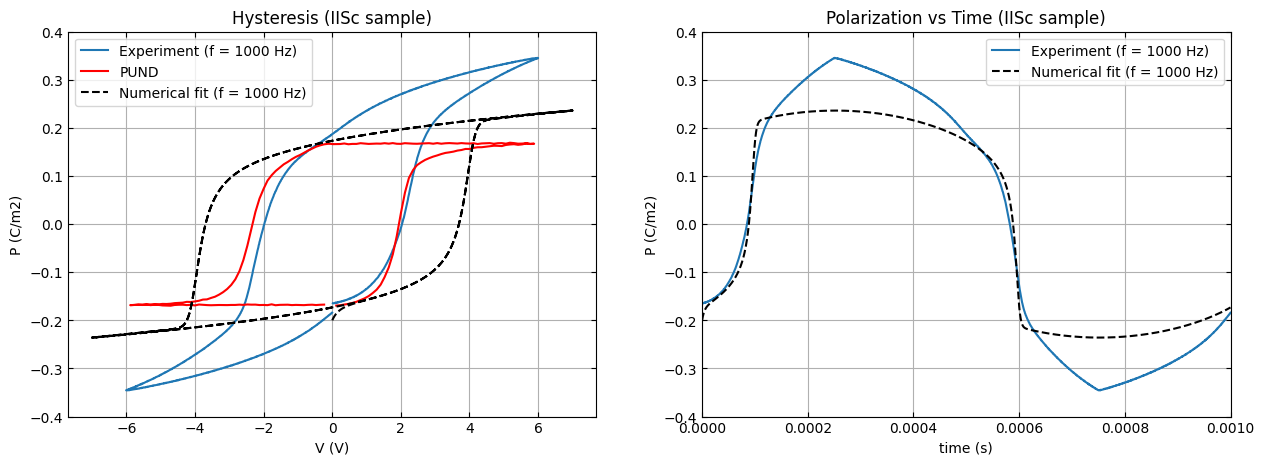

In [26]:
dt = 100e-9
t, Edrive = sin_wave(7/tf, 1000, dt)
P_fit =TDGL(t, -0.2 , Edrive, alpha, beta, rho)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(V_drive, P, label = f"Experiment (f = 1000 Hz)")
plt.plot(voltage_PUND, polarization_PUND, label = f"PUND", c = "red")
plt.ylim([-0.4, 0.4])

# plt.plot(V_drive_post/tf, P_post, label = f"f = {f_data[2]} Hz post")
plt.plot(Edrive*tf, P_fit,"--", c = 'black', label = "Numerical fit (f = 1000 Hz)")
plt.ylabel("P (C/m2)")
plt.xlabel("V (V)")
plt.legend()
plt.grid()
# plt.title(f"alpha = {alpha:.2}, beta = {beta:.2}, rho = {rho} (range)")
plt.title("Hysteresis (IISc sample)")
plt.tick_params(axis='both', direction='in', top=True, right=True  )

plt.subplot(1,2,2)
plt.plot(time, P, label = f"Experiment (f = 1000 Hz)")
# plt.plot(time_post, P_post, label = f"f = {f_data[2]} Hz post")
plt.plot(t[0:int(len(t)/2)], P_fit[0:int(len(t)/2)],"--", c = 'black', label = "Numerical fit (f = 1000 Hz)")
plt.ylim([-0.4, 0.4])
plt.xlim([0, 0.001])
plt.xlabel("time (s)")
plt.ylabel("P (C/m2)")
plt.legend()
plt.grid()
plt.title("Polarization vs Time (IISc sample)")
plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.savefig("fig//IISc_PV_hyst_P_t_data.pdf")

### Simulation

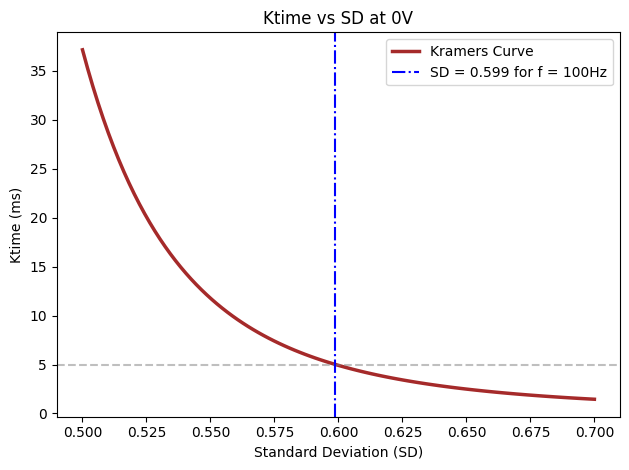

In [27]:
sd_range = np.linspace(0.5,0.7,100)
rho = 1400
Ktime = sr.calculate_kramer_curve(sd_range, 0, alpha, beta, rho, bw, tf, Af)

# Plot the curve
plt.plot(sd_range, Ktime*1e3, linewidth = 2.5, color = "brown", label='Kramers Curve')
c = ["blue", "black", "red"]
# Target Ktime in ms
fsig = [100]
sd_opt_f = []
for i, f in enumerate(fsig):
    target_time = 1/(2*f)
    interp_fn = interp1d(Ktime, sd_range, bounds_error=False, fill_value="extrapolate")
    sd_opt = interp_fn(target_time)
    sd_opt_f.append(sd_opt)
    Dext_delF_opt = sr.Dext_delF(sd_opt, bw, alpha, beta, rho, tf, Af)[0]
    # Draw horizontal line at target time
    plt.axhline(y=target_time*1e3, color='gray', linestyle='--', alpha = 0.5)
    # Draw vertical line at corresponding SD
    plt.axvline(x=sd_opt, color=c[i], linestyle='-.', label=f'SD = {sd_opt:.3f} for f = {f}Hz')
# Axis labels and title
plt.xlabel('Standard Deviation (SD)')
plt.ylabel('Ktime (ms)')
plt.title('Ktime vs SD at 0V')
plt.legend()
# plt.grid(True)
plt.tight_layout()

In [28]:
Asig = params.get('A')
# fsig = params.get('f')
fsig = [100]
clr = ["blue", "black", "red"]
styl = ["-s", "-o", "-^"]
Dext_DelF_opt = sd2Dext_delF(np.array(sd_opt_f), rho, bw, tf, delF)
for i in range(len(fsig)):
    f = fsig[i]
    A = Asig[0]
    sd_crt, bw_crt, Dext_delF, Dext_delF_crt, PSR, NF, SNR, COV = SR_matrics(params, f, A, raw_data_file, delw=5, delw_noise = 70)

In [9]:
# # full Range
# plt.figure(figsize=(5,15))
# plt.subplot(3,1,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], label = f"f = {f} Hz")
# plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.ylim([0, 0.03]); plt.legend()
# plt.subplot(3,1,2); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], label = f"f = {f} Hz")
# plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$"); plt.ylim([-35, -15]);  plt.legend()
# plt.subplot(3,1,3); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], label = f"f = {f} Hz")
# plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.ylim([-10, 50]);  plt.legend()

# plt.savefig("fig//IISc_SR_metric_sim.pdf")

### Measurement

In [29]:
IISc_data_path = "C:\\Drive\\FE_SR\\IITPKD_data_analysis\\sim_for_final_figs\\IISc_data\\"

#load all the data's 75 Hz, 100Hz, 150 Hz
sd = np.linspace(0.0,5.1,35)
P_data = []
V_data = []
t_data = []

start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
f_data = [75, 100, 150]

#index after the poling pulse
fro = int(bw + 48)

for j in range(0,3):
    P_f = []
    V_f = []
    t_f = []
    for i in range(0,len(sd)):
        file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{sd[i]:.2f}.xls'    
        Ptemp, Vtemp, ttemp = load_data(file_path, start_i[j], end_i[j])    
        P_f.append(np.array(Ptemp[fro:]))
        V_f.append(np.array(Vtemp[fro:]))
        t_f.append(np.array(ttemp[fro:]))
    P_data.append(P_f)
    V_data.append(V_f)
    t_data.append(t_f)

# reading Hyst data (for the super threshold signal)
PV_data = pd.read_excel(IISc_data_path + "hyst_1000hz.xlsx")
Pswitch = np.array(PV_data.iloc[46:43+2002, 3].to_list())*1e-2 # 1e-6/1e-2/1e-2 (C/m2 conversion)
tswitch = np.array(PV_data.iloc[46:43+2002, 1].to_list())*1e-3

In [30]:
for i in [1]:#range(len(f_data)):
    V = V_data[i]
    V0 = V_data[i][0]
    P = P_data[i]
    
    # code to make the Pswitch signal
    P_switch = list(Pswitch*2/3)*75
    time_switch = np.linspace(t_data[i][0][0], t_data[i][0][-1], len(P_switch))
    time_switch_gen = t_data[i][0]
    interp_func = interp1d(time_switch, P_switch, kind='linear', fill_value='extrapolate')
    P_switch_gen = interp_func(time_switch_gen)

    sd_crt_exp, bw_crt_exp, Dext_delF_exp, Dext_delF_crt_exp, PSR_exp, NF_exp, SNR_exp, COV_exp = SR_matrics_exp(sd, V, P, V0, P_switch_gen, bw, f_data[i], alpha, beta, rho, tf, Af, delw=4, delw_noise = 70)
    

In [12]:
# styl = ["s", "o", "^"]
# plt.figure(figsize=(20,5))
# plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], c = clr[i], label = f"f = {f_data[i]} Hz"); plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
# plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i],  c = clr[i], label = f"f = {f_data[i]} Hz"); plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
# plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i],  c = clr[i], label = f"f = {f_data[i]} Hz"); plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()

### Simulation vs Measurment

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_15976\426582291.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_15976\426582291.py:12: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_15976\426582291.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_15976\426582291.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xla

IndexError: list index out of range

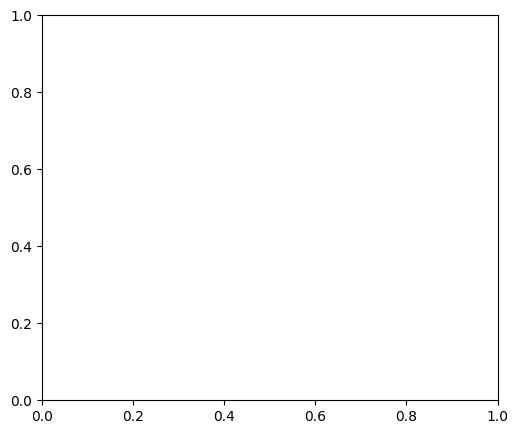

In [31]:
# Measurement only
lwth = 1
mwth = 2
clr = ["black"]
styl = ["o"]
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], linewidth = lwth, mew = mwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i], linewidth = lwth, mew = mwth,  c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i], linewidth = lwth, mew = mwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.savefig("fig//IISc_SR_metric_meas.pdf")


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_18680\3490932950.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_18680\3490932950.py:12: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_18680\3490932950.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored w

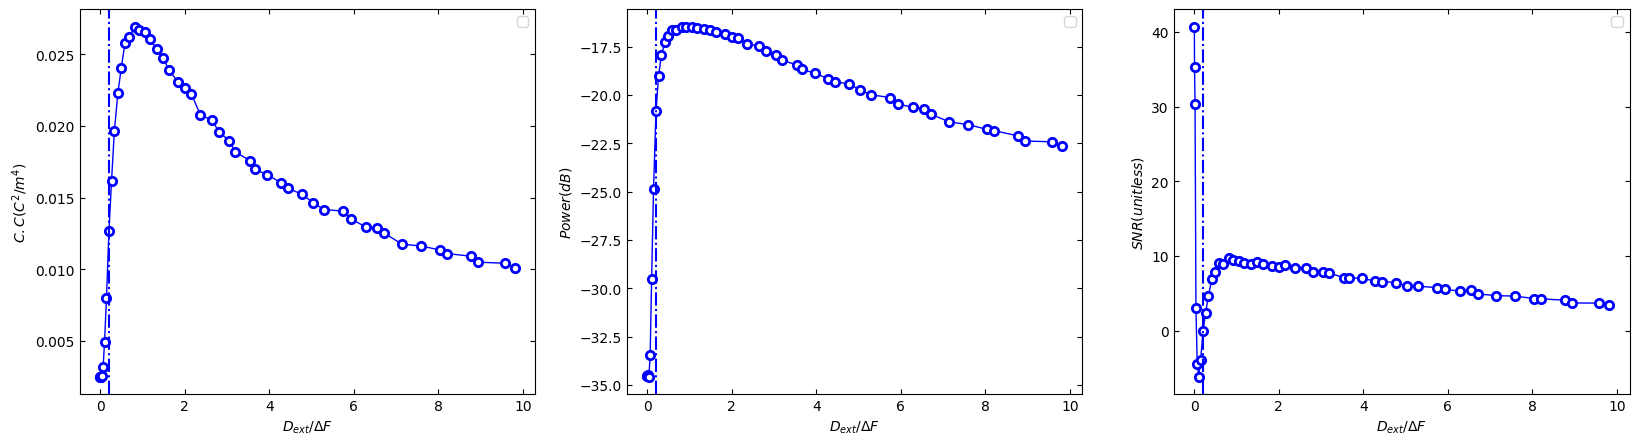

In [ ]:
# Simulation only
lwth = 1
mwth = 2
clr = ["blue"]
styl = ["-o"]
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plt.plot(Dext_delF_crt, COV, styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2); plt.plot(Dext_delF_crt, 10*np.log10(PSR), styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white',  c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3); plt.plot(Dext_delF_crt, 10*np.log10(SNR), styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.savefig("fig//IISc_SR_metric_sim.pdf")


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_18680\881519084.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
C:\Users\manik\AppData\Local\Temp\ipykernel_18680\881519084.py:12: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
C:\User

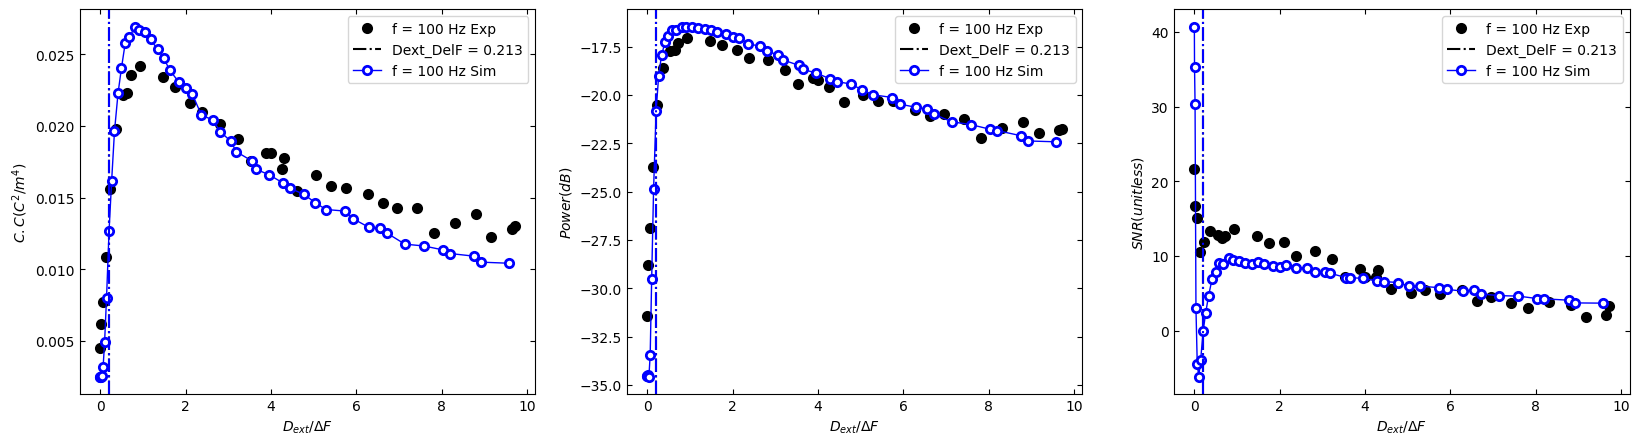

In [ ]:
# Simulation vs Measurement
lwth = 1
mwth = 2
clr = ["black"]
styl = ["o"]
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plt.plot(Dext_delF_crt_exp, COV_exp, styl[i], linewidth = lwth, mew = mwth, c = clr[i], label = f"f = {f} Hz Exp")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2); plt.plot(Dext_delF_crt_exp, 10*np.log10(PSR_exp), styl[i], linewidth = lwth, mew = mwth,  c = clr[i], label = f"f = {f} Hz Exp")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3); plt.plot(Dext_delF_crt_exp, 10*np.log10(SNR_exp), styl[i], linewidth = lwth, mew = mwth, c = clr[i], label = f"f = {f} Hz Exp")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

lwth = 1
mwth = 2
clr = ["blue"]
styl = ["-o"]
to = -1
plt.subplot(1,3,1); plt.plot(Dext_delF_crt[0:to], COV[0:to], styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white', c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,2); plt.plot(Dext_delF_crt[0:to], 10*np.log10(PSR[0:to]), styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white',  c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(1,3,3); plt.plot(Dext_delF_crt[0:to], 10*np.log10(SNR[0:to]), styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white', c = clr[i],label = f"f = {f} Hz Sim")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.savefig("fig//IISc_SR_metric_simvsmeas.pdf")

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:44: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:44: SyntaxWarning: invalid escape sequence '\D'
C:\Users\manik\AppData\Local\Temp\ipykernel_18680\1090579004.py:9: SyntaxWarning: in

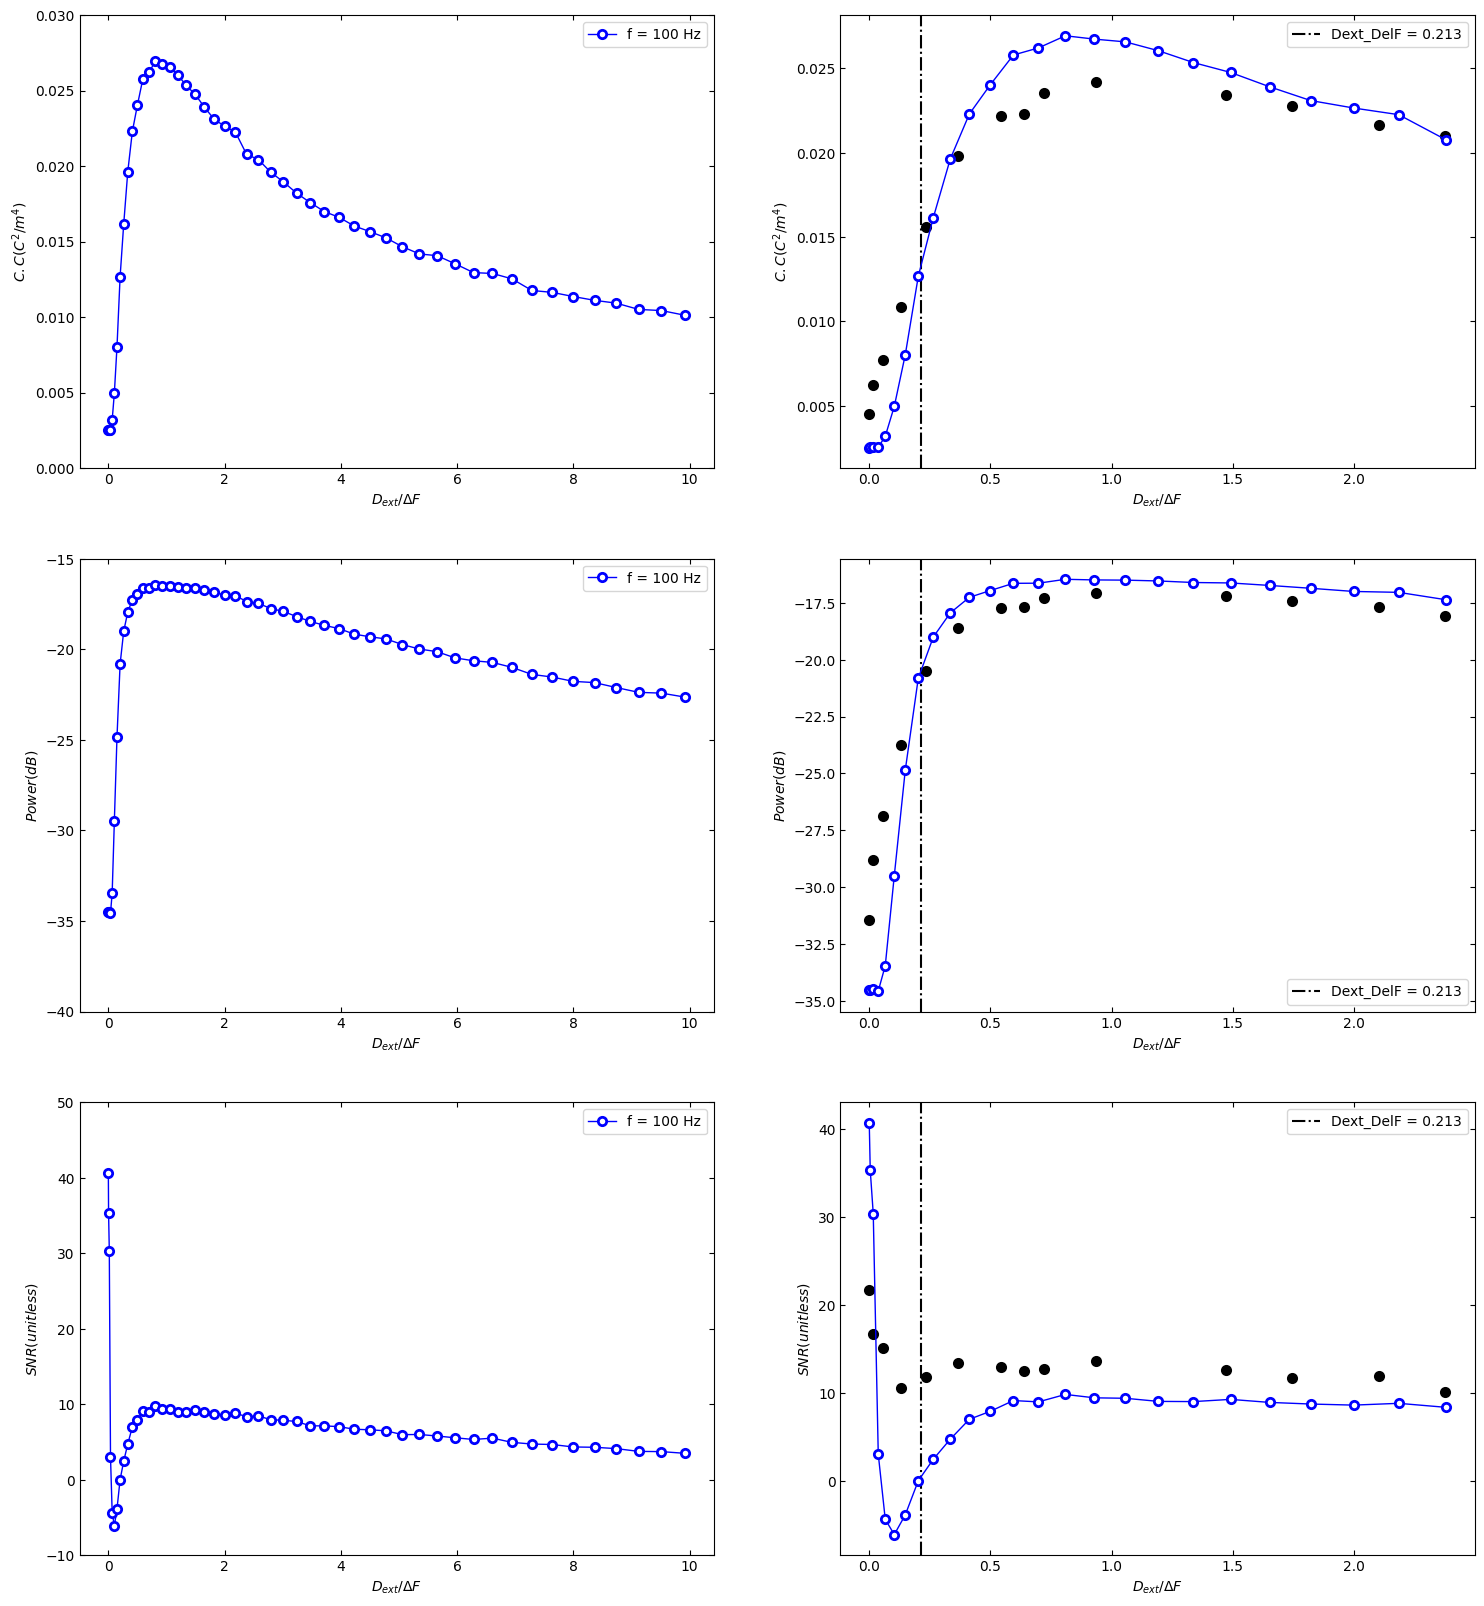

In [ ]:
lwth = 1
mwth = 2
clr = ["blue"]
styl = ["-o"]

plt.figure(figsize=(18, 20))

plt.subplot(3,2,1); plt.plot(Dext_delF, COV,styl[i], c = clr[i], linewidth = lwth, mew = mwth, markerfacecolor='white', label = f"f = {f} Hz")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.ylim([0, 0.03]); plt.legend()
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,3); plt.plot(Dext_delF, 10*np.log10(PSR),styl[i],  c = clr[i], linewidth = lwth, mew = mwth, markerfacecolor='white', label = f"f = {f} Hz")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$"); plt.ylim([-40, -15]);  plt.legend()
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,5); plt.plot(Dext_delF, 10*np.log10(SNR),styl[i],  c = clr[i], linewidth = lwth, mew = mwth, markerfacecolor='white', label = f"f = {f} Hz")
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.ylim([-10, 50]);  plt.legend()
plt.tick_params(axis='both', direction='in', top=True, right=True  )

to = 14
clr = ["black"]
styl = ["o"]
plt.subplot(3,2,2); plt.plot(Dext_delF_crt_exp[0:to], COV_exp[0:to], styl[i], linewidth = lwth, mew = mwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,4); plt.plot(Dext_delF_crt_exp[0:to], 10*np.log10(PSR_exp[0:to]), styl[i], linewidth = lwth, mew = mwth,  c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$");  plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,6); plt.plot(Dext_delF_crt_exp[0:to], 10*np.log10(SNR_exp[0:to]), styl[i], linewidth = lwth, mew = mwth, c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$"); plt.legend()
plt.axvline(x=Dext_DelF_opt[0], color=clr[i], linestyle='-.', label=f'Dext_DelF = {Dext_DelF_opt[0]:.3f}') # Draw vertical line at corresponding SD
plt.tick_params(axis='both', direction='in', top=True, right=True  )

clr = ["blue"]
styl = ["-o"]
to = 25
plt.subplot(3,2,2); plt.plot(Dext_delF[0:to], COV[0:to],styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$C.C (C^2/m^4)$"); plt.legend()
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,4); plt.plot(Dext_delF[0:to], 10*np.log10(PSR[0:to]),styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white', c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$Power (dB)$"); plt.legend()
plt.tick_params(axis='both', direction='in', top=True, right=True  )
plt.subplot(3,2,6); plt.plot(Dext_delF[0:to], 10*np.log10(SNR[0:to]),styl[i], linewidth = lwth, mew = mwth, markerfacecolor='white',  c = clr[i])
plt.xlabel("$D_{ext} / \Delta F$"); plt.ylabel("$SNR (unitless)$");plt.legend()
plt.tick_params(axis='both', direction='in', top=True, right=True  )

# plt.savefig("fig//IISc_SR_metric_simvsmeas_2.pdf")

### Time series plots

Top Row SD = 0.33
Top Row SD = 1.14
Top Row SD = 3.02
Bottom Row SD = 0.3
Bottom Row SD = 1.05
Bottom Row SD = 3.0


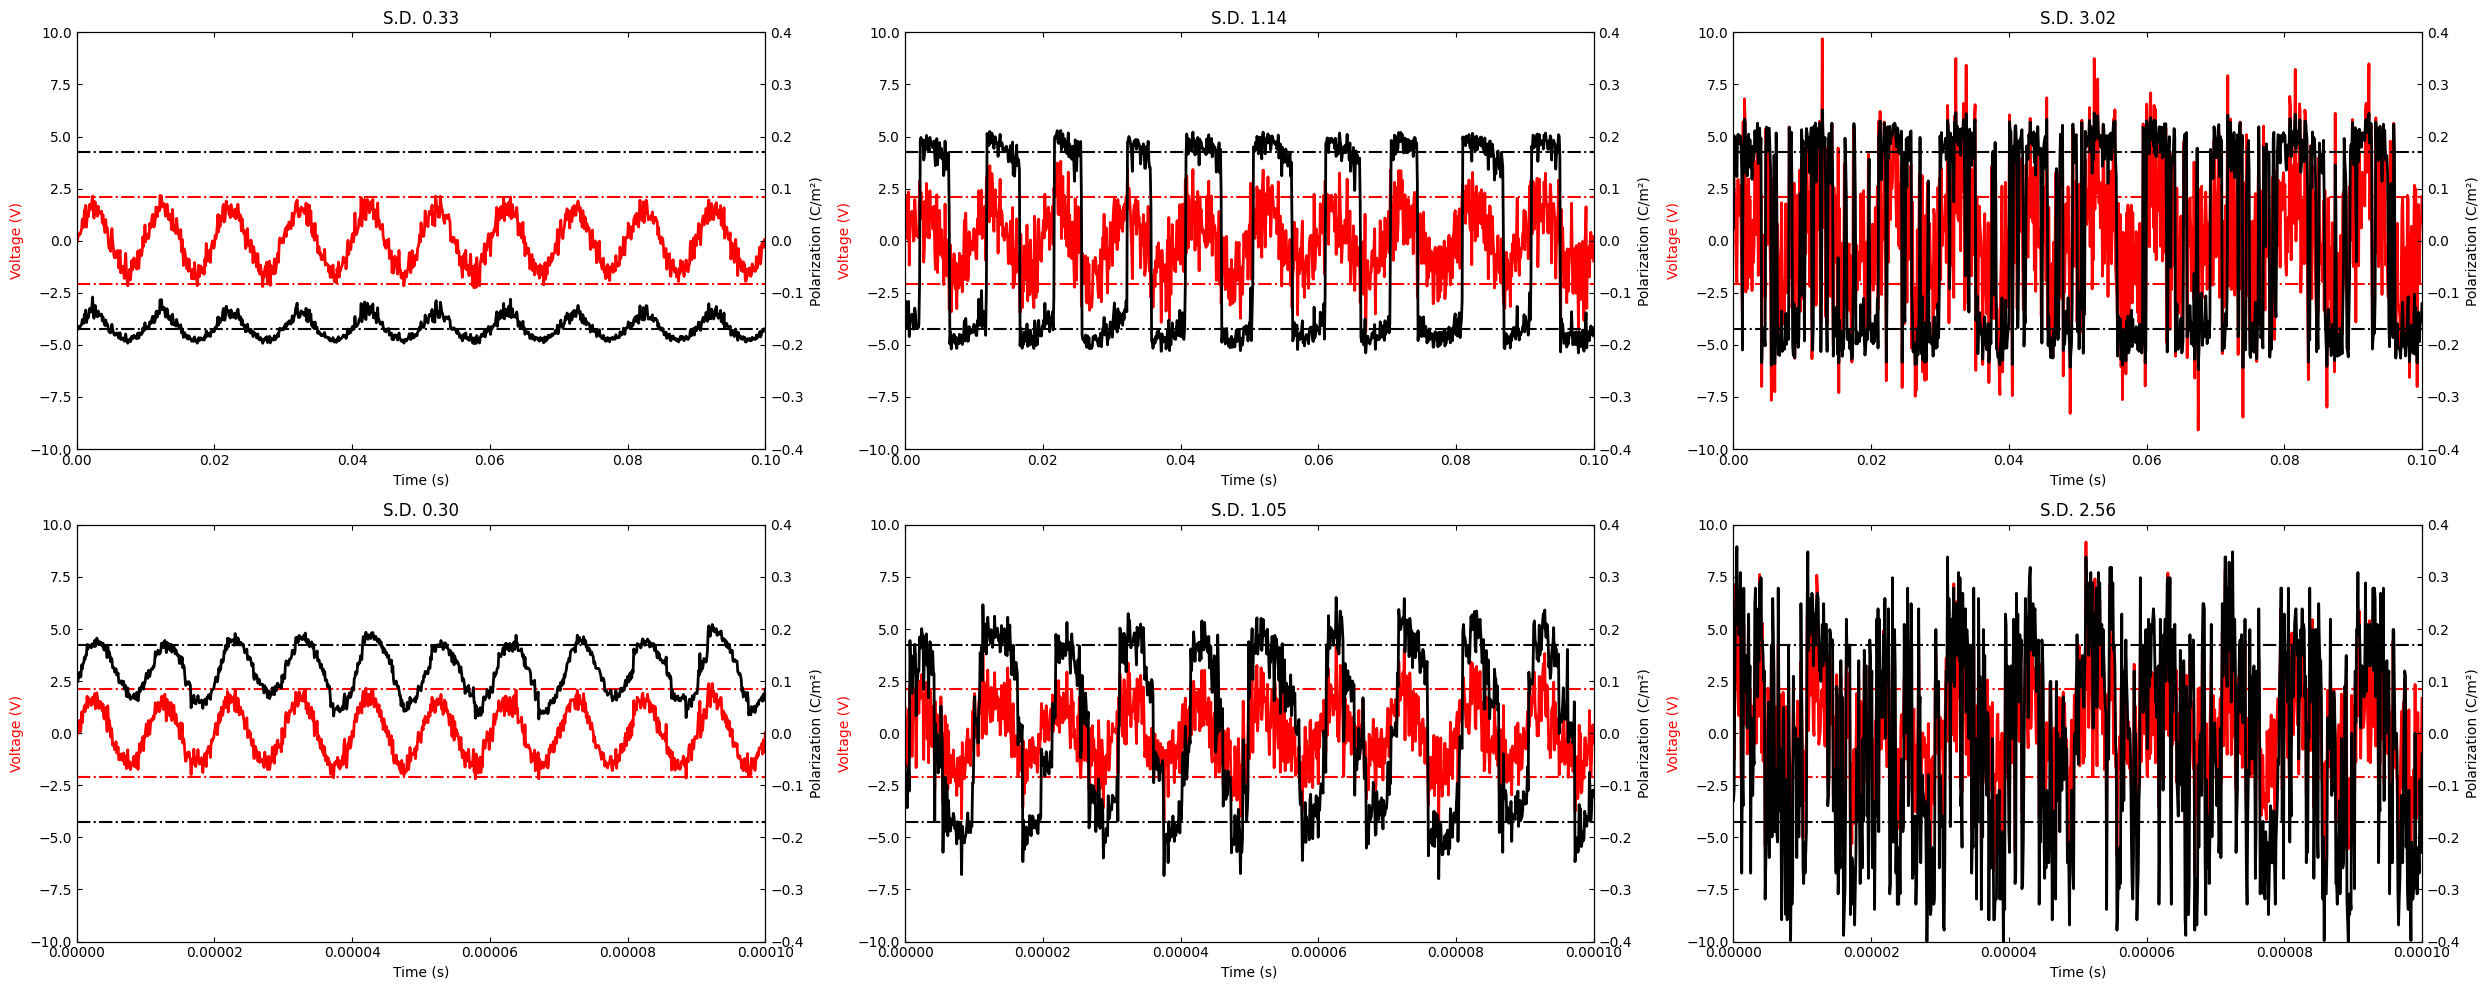

In [32]:
sd_values_top = [0.33, 1.14, 3.02]
sd_values_bottom = [0.3, 1.05, 3.0]
clr = ["red", "black"]
lnwidth = [2, 2]
dt_top = 1e-4
dt_bottom = 1e-4
alpha_P = 1
alpha_V = 1

fro1_top = 0
fro1_bottom = int(bw + 48+500)

no_cycle = 10

to1_top = int(fro1_top + no_cycle / (100 * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (100 * dt_bottom) + 1)

V_range = 10
P_range = 0.4

Vc = 2.1
Pr = 0.17


plt.figure(figsize=(25, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+1)
    ax1.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0])
    ax1.set_ylim([-V_range, V_range])
    ax1.set_xlim(t_data[0], t_data[-1])
    ax1.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax1.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax1.set_ylabel('Voltage (V)', color=clr[0])
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f"S.D. {sd:.2f}")
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()
    ax2.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1])
    ax2.set_ylim([-P_range, P_range])
    ax2.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax2.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax2.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax2.tick_params(axis='both', direction='in', top=True, right=True)

# for finding the corrected sd
start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
#index after the poling pulse
fro = int(bw + 48)
j = 1
file_path = IISc_data_path + f'new_100Hz\\0.00.xls'   
t_data, V_data, P_data = load_data(file_path, start_i[j], end_i[j])    
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{sd:.2f}.xls'
    P_data, V_data, t_data = load_data(file_path, start_i[j], end_i[j])
    sd_crt_plt =  sr.sd_correction(V_data[fro:],V0)
    dt = (t_data[1] - t_data[0])*1e-3
    V_data = V_data[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    V_data = V_data[::1]
    P_data = P_data[::1]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)
    ax1.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0])
    ax1.set_ylim([-V_range, V_range])
    ax1.set_xlim(t_data[0], t_data[-1])
    ax1.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax1.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax1.set_ylabel('Voltage (V)', color=clr[0])
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()
    ax2.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1])
    ax2.set_ylim([-P_range, P_range])
    ax2.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax2.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax2.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax2.tick_params(axis='both', direction='in', top=True, right=True)

plt.tight_layout()
# plt.savefig("fig//IISc_P_t_data.pdf")
plt.show()


Top Row SD = 0.33
Top Row SD = 1.14
Top Row SD = 3.02
Bottom Row SD = 0.3
Bottom Row SD = 1.05
Bottom Row SD = 3.0


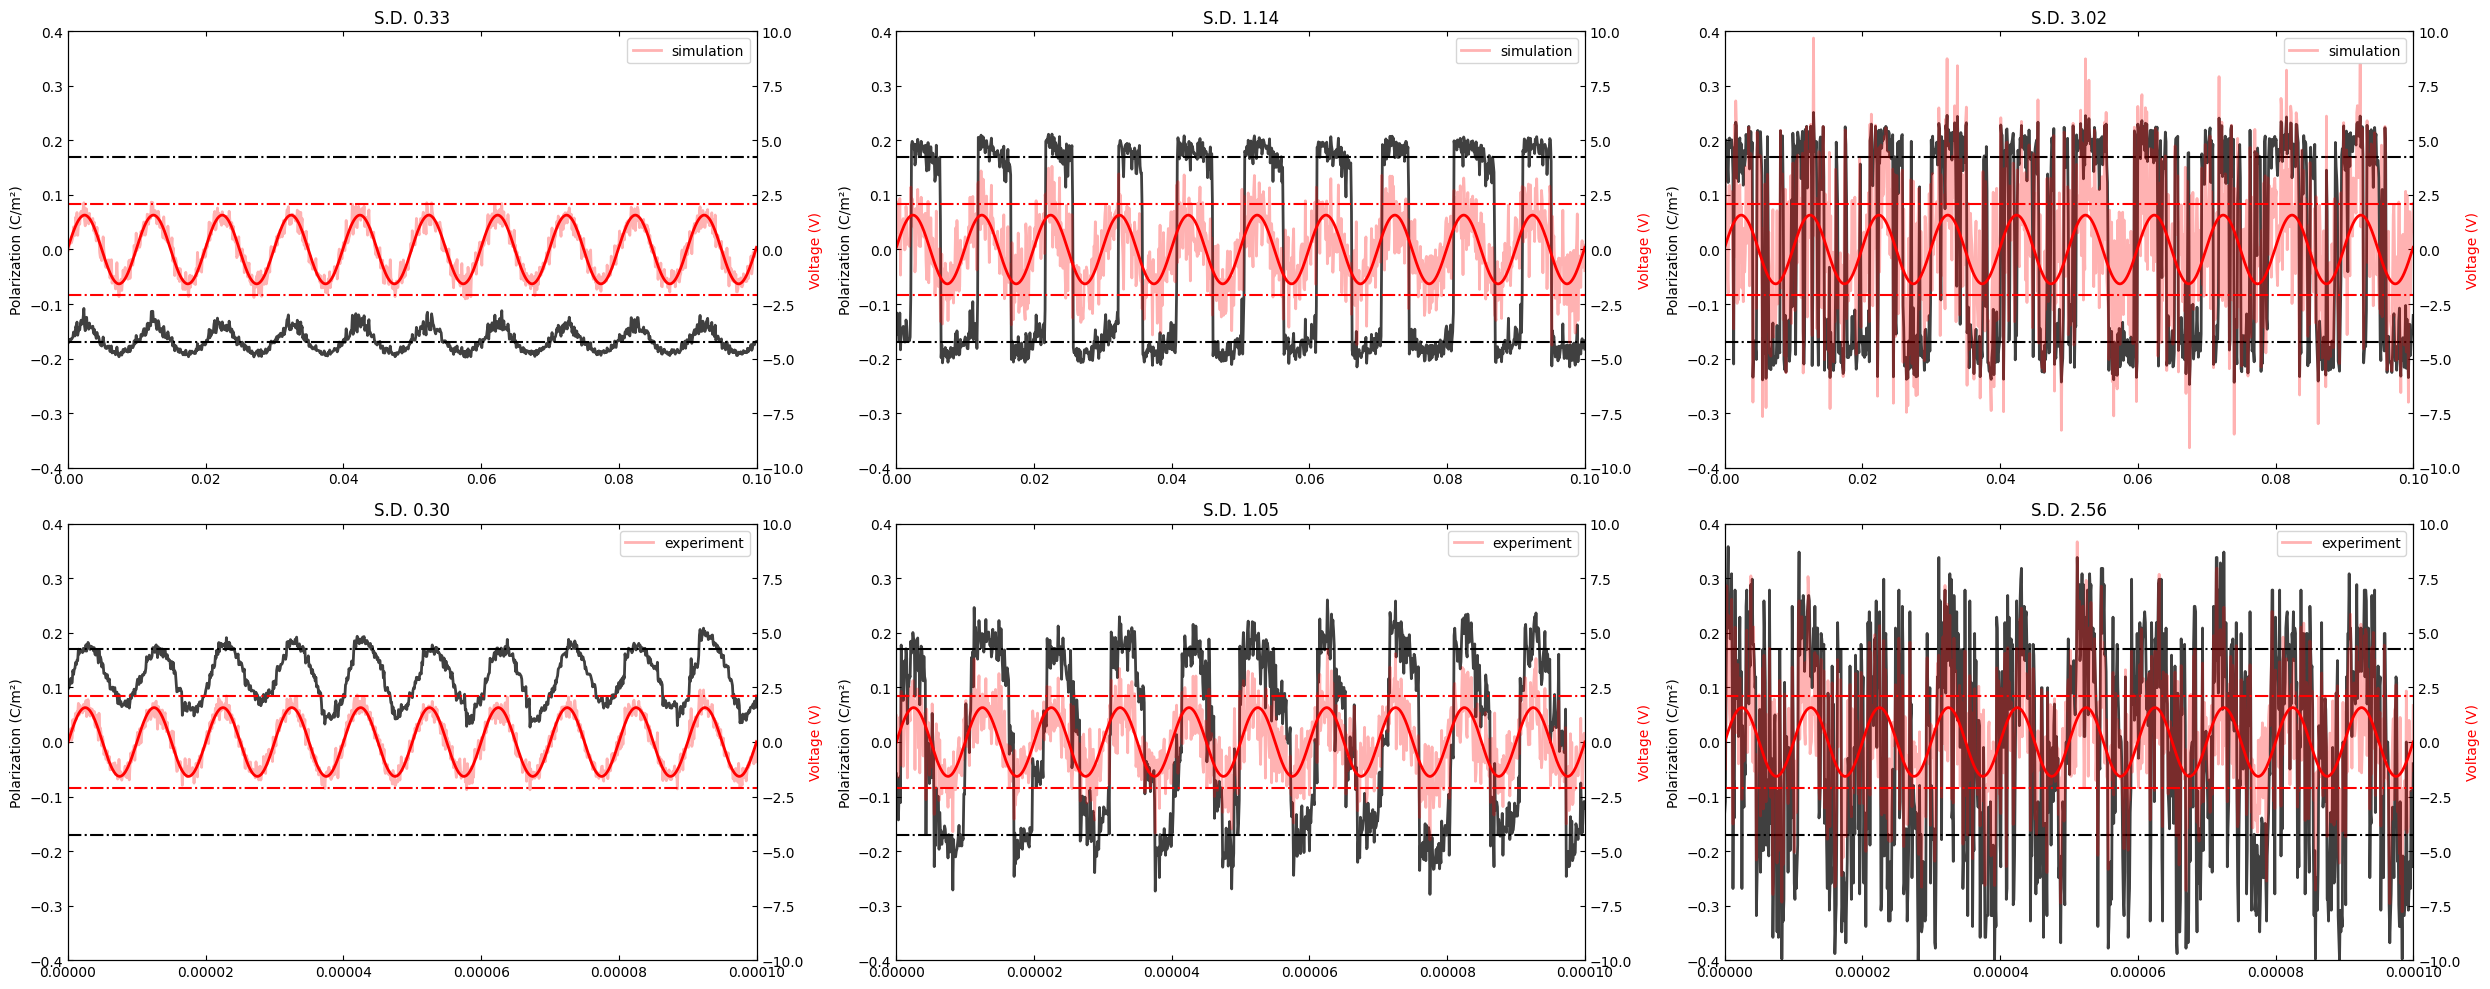

In [39]:
sd_values_top = [0.33, 1.14, 3.02]
sd_values_bottom = [0.3, 1.05, 3.0]
clr = ["red", "black"]
lnwidth = [2, 2]
dt_top = 1e-4
dt_bottom = 1e-4
alpha_P = 0.75
alpha_V = 0.3

fro1_top = 0
fro1_bottom = int(bw + 48+500)

no_cycle = 10

to1_top = int(fro1_top + no_cycle / (100 * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (100 * dt_bottom) + 1)

V_range = 10
P_range = 0.4

Vc = 2.1
Pr = 0.17


plt.figure(figsize=(25, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    t_data, V_data_0, _ = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{0:.2f}_ens{1}.txt')

    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    V_data_0 = V_data_0[fro1_top:to1_top] * tf
    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+1)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.tick_params(axis='both', direction='in', top=True, right=True)
    
    ax2 = ax1.twinx()

    ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f"S.D. {sd:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["simulation"])

    

# for finding the corrected sd
start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
#index after the poling pulse
fro = int(bw + 48)
j = 1
file_path = IISc_data_path + f'new_100Hz\\0.00.xls'   
t_data, V_data, P_data = load_data(file_path, start_i[j], end_i[j])    
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{sd:.2f}.xls'
    P_data, V_data, t_data = load_data(file_path, start_i[j], end_i[j])
    file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{0.00:.2f}.xls'
    _, V_data_0, t_data = load_data(file_path, start_i[j], end_i[j])

    sd_crt_plt =  sr.sd_correction(V_data[fro:],V0)
    dt = (t_data[1] - t_data[0])*1e-3
    V_data = V_data[fro1_bottom:to1_bottom]
    V_data_0 = V_data_0[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    V_data = V_data[::1]
    V_data_0 = V_data_0[::1]
    P_data = P_data[::1]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()

    ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["experiment"])


plt.tight_layout()
plt.savefig("fig//IISc_P_t_data_1.pdf")
plt.show()


Top Row SD = 0.33
Top Row SD = 1.14
Top Row SD = 3.02
Bottom Row SD = 0.3
Bottom Row SD = 1.05
Bottom Row SD = 3.0


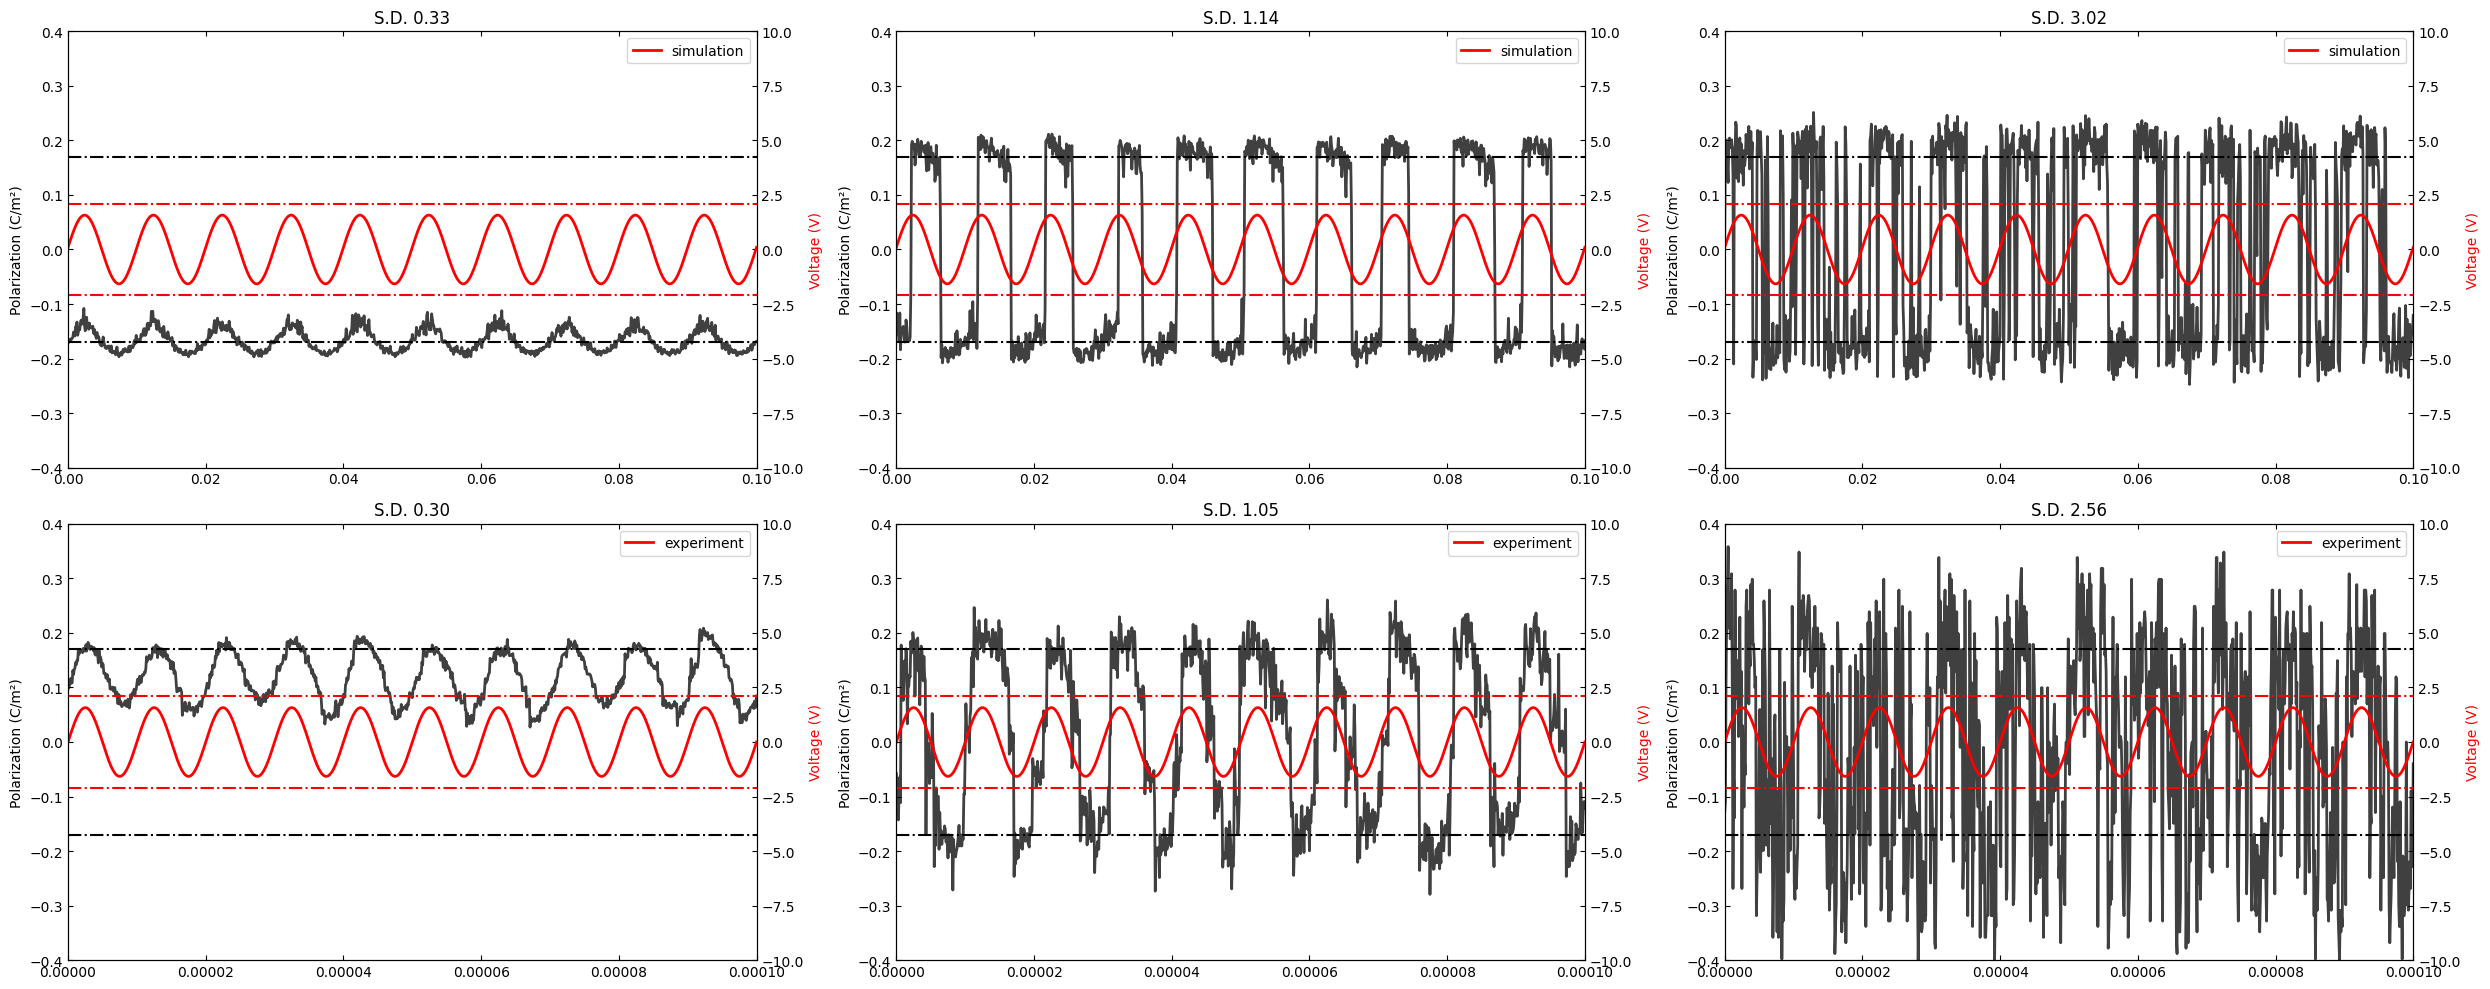

In [40]:
sd_values_top = [0.33, 1.14, 3.02]
sd_values_bottom = [0.3, 1.05, 3.0]
clr = ["red", "black"]
lnwidth = [2, 2]
dt_top = 1e-4
dt_bottom = 1e-4
alpha_P = 0.75
alpha_V = 0.3

fro1_top = 0
fro1_bottom = int(bw + 48+500)

no_cycle = 10

to1_top = int(fro1_top + no_cycle / (100 * dt_top) + 1)
to1_bottom = int(fro1_bottom + no_cycle / (100 * dt_bottom) + 1)

V_range = 10
P_range = 0.4

Vc = 2.1
Pr = 0.17


plt.figure(figsize=(25, 10))
# First row
for e, sd in enumerate(sd_values_top):
    print(f"Top Row SD = {sd}")
    t_data, V_data, P_data = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{sd:.2f}_ens{1}.txt')
    t_data, V_data_0, _ = sr.read_tEP_data(raw_data_file + f'\\PE_{f}hz_{A}V_sd{0:.2f}_ens{1}.txt')

    dt = t_data[1] - t_data[0]
    V_data = V_data[fro1_top:to1_top] * tf
    V_data_0 = V_data_0[fro1_top:to1_top] * tf
    P_data = P_data[fro1_top:to1_top]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+1)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth =  lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.tick_params(axis='both', direction='in', top=True, right=True)
    
    ax2 = ax1.twinx()

    # ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f"S.D. {sd:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["simulation"])

    

# for finding the corrected sd
start_i, end_i = [45, 45, 45], [20067, 17592, 15042] #index of the data
#index after the poling pulse
fro = int(bw + 48)
j = 1
file_path = IISc_data_path + f'new_100Hz\\0.00.xls'   
t_data, V_data, P_data = load_data(file_path, start_i[j], end_i[j])    
V0 =  V_data[fro:]

# Second row
for e, sd in enumerate(sd_values_bottom):
    print(f"Bottom Row SD = {sd}")
    file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{sd:.2f}.xls'
    P_data, V_data, t_data = load_data(file_path, start_i[j], end_i[j])
    file_path = IISc_data_path + f'new_{f_data[j]}Hz\\{0.00:.2f}.xls'
    _, V_data_0, t_data = load_data(file_path, start_i[j], end_i[j])

    sd_crt_plt =  sr.sd_correction(V_data[fro:],V0)
    dt = (t_data[1] - t_data[0])*1e-3
    V_data = V_data[fro1_bottom:to1_bottom]
    V_data_0 = V_data_0[fro1_bottom:to1_bottom]
    P_data = P_data[fro1_bottom:to1_bottom]
    V_data = V_data[::1]
    V_data_0 = V_data_0[::1]
    P_data = P_data[::1]
    t_data = np.linspace(0, (len(V_data)-1)*dt, len(V_data))
    V_data = np.clip(V_data, -V_range, V_range)
    P_data = np.clip(P_data, -P_range, P_range)

    ax1 = plt.subplot(2, 3, e+4)
    
    ax1.plot(t_data, P_data, color=clr[1], linewidth = lnwidth[1], alpha = alpha_P)
    ax1.set_ylim([-P_range, P_range])
    ax1.axhline(y=Pr, linestyle='-.', color=clr[1])
    ax1.axhline(y=-Pr, linestyle='-.', color=clr[1])
    ax1.set_ylabel('Polarization (C/m²)', color=clr[1])
    ax1.tick_params(axis='both', direction='in', top=True, right=True)

    ax2 = ax1.twinx()

    # ax2.plot(t_data, V_data, color=clr[0], linewidth = lnwidth[0], alpha = alpha_V)
    ax2.plot(t_data, V_data_0, color=clr[0], linewidth = lnwidth[0])

    ax2.set_ylim([-V_range, V_range])
    ax2.set_xlim(t_data[0], t_data[-1])
    ax2.axhline(y=Vc, linestyle='-.', color=clr[0])
    ax2.axhline(y=-Vc, linestyle='-.', color=clr[0])
    ax2.set_ylabel('Voltage (V)', color=clr[0])
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f"S.D. {sd_crt_plt:.2f}")
    ax2.tick_params(axis='both', direction='in', top=True, right=True)
    ax2.legend(["experiment"])


plt.tight_layout()
plt.savefig("fig//IISc_P_t_data_2.pdf")
plt.show()
